INTERFACE WITH GOOGLE DRIVE

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [40]:
uploaded = drive.CreateFile({'test': 'Sample.txt'})
uploaded.SetContentString('Sample upoad file content')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

#downloaded = drive.CreateFile({'id': uploaded.get('id')})
#print('Downloaded content"{}"'.format(downloaded.GetContentString()))

# List .txt files in the root.
#
# Search query reference:
# https://developers.google.com/drive/v2/web/search-parameters
# listed = drive.ListFile({'q': "title contains '.txt' and 'root' in parents"}).GetList()
# for file in listed:
#   print('title {}, id {}'.format(file['title'], file['id']))

Uploaded file with ID 13K4g4LUKOmIr5fsJiWYVnUNPVfAm_T32


IMPORTS

In [0]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.axes import Axes as ax
import scipy
from PIL import Image
from scipy import ndimage
from scipy.misc import imsave
import tensorflow as tf
from tensorflow.python.framework import ops
from datetime import datetime
%matplotlib inline
np.random.seed(1)

DATASET

In [0]:
 def load_dataset():
    from google.colab import files
    uploaded = files.upload()

    for name, data in uploaded.items():
      with open(name, 'wb') as f:
        f.write(data)
        print ('saved file', name)

    X_train = np.load('X_train.npy')
    Y_train = np.load('Y_train.npy')
    #X_dev   = np.load('X_dev.npy')
    #Y_dev   = np.load('Y_dev.npy')
    X_test  = np.load('X_test.npy')
    Y_test  = np.load('Y_test.npy')

    return X_train, Y_train, X_test, Y_test #, X_dev, Y_dev

In [3]:
X_train, Y_train, X_test, Y_test = load_dataset() #X_dev, Y_dev

saved file X_test.npy
saved file X_train.npy
saved file Y_test.npy
saved file Y_train.npy


PRINT OUT EXAMPLE IMAGE

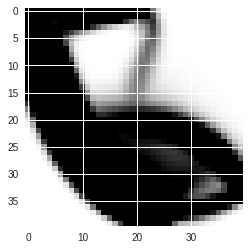

In [31]:
index = 25
example = X_train[index,:,:]
fig = plt.figure()
plt.imshow(example, cmap="binary")
plt.show()

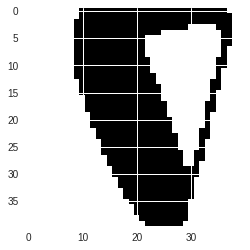

In [5]:
index = 400
example = Y_train[index,:,:]
fig = plt.figure()
plt.imshow(example, cmap="binary")
plt.show()

AUGMENT DATA

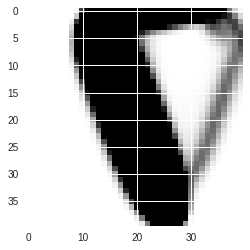

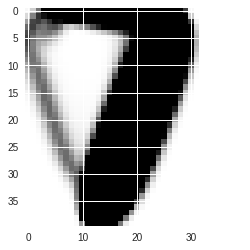

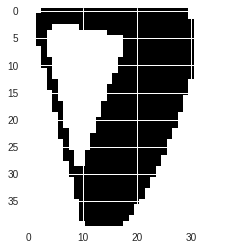

In [6]:
index = 400

example = X_train[index,:,:]
fig = plt.figure()
plt.imshow(example, cmap="binary")
plt.show()


new_data_X = np.flip(X_train, axis = 2) # should be 1 and 2
new_data_Y = np.flip(Y_train, axis = 2)

# CHECK
example = new_data_X[index,:,:]
fig = plt.figure()
plt.imshow(example, cmap="binary")
plt.show()

example = new_data_Y[index,:,:]
fig = plt.figure()
plt.imshow(example, cmap="binary")
plt.show()


X_train= np.concatenate((X_train, new_data_X), axis = 0)
Y_train = np.concatenate((Y_train, new_data_Y), axis = 0)

In [7]:
print ("number of training examples = " + str(X_train.shape[0]))
#print ("number of dev examples = " + str(X_dev.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
#print ("X_dev shape: " + str(X_dev.shape))
#print ("Y_dev shape: " + str(Y_dev.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 16000
number of test examples = 1000
X_train shape: (16000, 40, 40)
Y_train shape: (16000, 40, 40)
X_test shape: (1000, 40, 40)
Y_test shape: (1000, 40, 40)


FRAMEWORK FUNCTIONS

In [0]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    X = tf.placeholder(tf.float32, shape = [None, n_H0, n_W0, n_C0], name = 'X')
    Y = tf.placeholder(tf.float32, shape = [None, n_y], name = 'Y')
    
    return X, Y

def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow.
    
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    f1 = 16
    f2 = 32
    f3 = 64
    
    tf.set_random_seed(1)

    W1 = tf.get_variable("W1", [3,3,1,f1], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [3,3,f1,f1], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    
    W3 = tf.get_variable("W3", [3,3,f1,f2], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W4 = tf.get_variable("W4", [3,3,f2,f2], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    
    W5 = tf.get_variable("W5", [3,3,f2,f3], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W6 = tf.get_variable("W6", [3,3,f3,f3], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    
    W7 = tf.get_variable("W7", [3,3,f3,f3], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W8 = tf.get_variable("W8", [3,3,f3,f3], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    
    W9 = tf.get_variable("W9", [3,3,f3+f2,f2], initializer = tf.contrib.layers.xavier_initializer(seed = 0)) ### 32
    W10 = tf.get_variable("W10", [3,3,f2,f2], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    
    W11 = tf.get_variable("W11", [3,3,f1+f2,f1], initializer = tf.contrib.layers.xavier_initializer(seed = 0)) ### 16
    W12 = tf.get_variable("W12", [3,3,f1,f1], initializer = tf.contrib.layers.xavier_initializer(seed = 0))

    W13 = tf.get_variable("W13", [1,1,f1,1], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    
    parameters = {"W1": W1,
                  "W2": W2, "W3": W3, "W4": W4, "W5": W5, "W6": W6,
                  "W7": W7,"W8": W8, "W9": W9, "W10": W10,
                  "W11": W11,"W12": W12, "W13": W13
                  }
    
    return parameters

def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples) mini_batch_size -- size of the mini-batches, integer
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y) """
    
    np.random.seed(seed) 
    m = X.shape[0]
    mini_batches = []

    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m)) 
    shuffled_X = X[permutation,:,:]                     # [m,40,40]
    shuffled_Y = Y[permutation,:,:].reshape((m,40*40))  # [m,40*40]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) 
    
    # MINIBATCH LOOP}
    for k in range(0, num_complete_minibatches):
      mini_batch_X = shuffled_X[k*mini_batch_size:(k+1)*mini_batch_size,:,:] #[64,40,40]
      mini_batch_X = mini_batch_X.reshape((mini_batch_size, shuffled_X.shape[1], shuffled_X.shape[2],1))
      
      mini_batch_Y = shuffled_Y[k*mini_batch_size:(k+1)*mini_batch_size,:]  #[m,1600]

      mini_batch = (mini_batch_X, mini_batch_Y)
      mini_batches.append(mini_batch)      

    # END CASE (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
      mini_batch_X = shuffled_X[num_complete_minibatches*mini_batch_size:m,:,:] 
      mini_batch_X = mini_batch_X.reshape(((m-mini_batch_size*(m%mini_batch_size)), shuffled_X.shape[1], shuffled_X.shape[2],1))
      
      mini_batch_Y = shuffled_Y[num_complete_minibatches*mini_batch_size:m,:]
      
      mini_batch = (mini_batch_X, mini_batch_Y)
      mini_batches.append(mini_batch)
    
    return mini_batches

def batch_norm(Z_in):
  epsilon = 1e-3
  batch_mean, batch_var = tf.nn.moments(Z_in,[0])
  scale = tf.Variable(tf.ones([100]))
  beta = tf.Variable(tf.zeros([100]))
  BN = tf.nn.batch_normalization(z_in,batch_mean,batch_var,beta,scale,epsilon)
  return BN
  
def forward_propagation(X, parameters, phase):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
    W4 = parameters['W4']
    W5 = parameters['W5']
    W6 = parameters['W6']
    W7 = parameters['W7']
    W8 = parameters['W8']
    W9 = parameters['W9']
    W10 = parameters['W10']
    W11 = parameters['W11']
    W12 = parameters['W12']
    W13 = parameters['W13']
    
    keep_probability = 0.7
    
    #### BLOCK 1 (16 channels) ####
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X, W1, strides = [1,1,1,1], padding = 'SAME')
    # BATCH NORMALIZATION
    #B1 = tf.contrib.layers.batch_norm(Z1, center = True, scale = True, is_training = phase)
    # RELU
    A1 = tf.nn.relu(Z1)
    
    # CONV2D: stride of 1, padding 'SAME'
    Z2 = tf.nn.conv2d(A1, W2, strides = [1,1,1,1], padding = 'SAME')
    # BATCH NORMALIZATION
    #B2 = tf.contrib.layers.batch_norm(Z2, center = True, scale = True, is_training = phase)
    # RELU
    A2 = tf.nn.relu(Z2) 
    
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
    
    
    #### BLOCK 2 (32 channels) ####
    # CONV2D: stride of 1, padding 'SAME'
    Z3 = tf.nn.conv2d(P1, W3, strides = [1,1,1,1], padding = 'SAME')
    # BATCH NORMALIZATION
    #B3 = tf.contrib.layers.batch_norm(Z3, center = True, scale = True, is_training = phase)
    # RELU
    A3 = tf.nn.relu(Z3)
    
    # DROPOUT
    D1 = tf.nn.dropout(A3, keep_prob = keep_probability)
    
    # CONV2D: stride of 1, padding 'SAME'
    Z4 = tf.nn.conv2d(D1, W4, strides = [1,1,1,1], padding = 'SAME')
    # BATCH NORMALIZATION
    #B4 = tf.contrib.layers.batch_norm(Z4, center = True, scale = True, is_training = phase)
    # RELU
    A4 = tf.nn.relu(Z4)
    
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P2 = tf.nn.max_pool(A4, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
    
    
    #### BLOCK 3 (64 channels) ####
    # CONV2D: stride of 1, padding 'SAME'
    Z5 = tf.nn.conv2d(P2, W5, strides = [1,1,1,1], padding = 'SAME')
    # BATCH NORMALIZATION
    #B5 = tf.contrib.layers.batch_norm(Z5, center = True, scale = True, is_training = phase)
    # RELU
    A5 = tf.nn.relu(Z5)
    
    # CONV2D: stride of 1, padding 'SAME'
    Z6 = tf.nn.conv2d(A5, W6, strides = [1,1,1,1], padding = 'SAME')
    # BATCH NORMALIZATION
    #B6 = tf.contrib.layers.batch_norm(Z6, center = True, scale = True, is_training = phase)
    # RELU
    A6 = tf.nn.relu(Z6)
    
    # CONV2D: stride of 1, padding 'SAME'
    Z7 = tf.nn.conv2d(A6, W7, strides = [1,1,1,1], padding = 'SAME')
    # BATCH NORMALIZATION
    #B7 = tf.contrib.layers.batch_norm(Z7, center = True, scale = True, is_training = phase)
    # RELU
    A7 = tf.nn.relu(Z7)
    
    # CONV2D: stride of 1, padding 'SAME'
    Z8 = tf.nn.conv2d(A7, W8, strides = [1,1,1,1], padding = 'SAME')
    # BATCH NORMALIZATION
    #B8 = tf.contrib.layers.batch_norm(Z8, center = True, scale = True, is_training = phase)
    # RELU
    A8 = tf.nn.relu(Z8)
    
    #### BLOCK 4 (32 channels) ####
    # UPSAMPLE
    U1 = tf.keras.layers.UpSampling2D((2,2))(A8)
    # CONCATENATE
    C1 = tf.concat([U1,A4], axis = 3)  # should have 64 channels - need to convolve down to 32
    # CONV2D: stride of 1, padding 'SAME'
    Z9 = tf.nn.conv2d(C1, W9, strides = [1,1,1,1], padding = 'SAME')
    # BATCH NORMALIZATION
    #B9 = tf.contrib.layers.batch_norm(Z9, center = True, scale = True, is_training = phase)
    # RELU
    A9 = tf.nn.relu(Z9)
    # DROPOUT
    D2 = tf.nn.dropout(A9, keep_prob = keep_probability)

    # CONV2D: stride of 1, padding 'SAME'
    Z10 = tf.nn.conv2d(D2, W10, strides = [1,1,1,1], padding = 'SAME')
    # BATCH NORMALIZATION
    #B10 = tf.contrib.layers.batch_norm(Z10, center = True, scale = True, is_training = phase)
    # RELU
    A10 = tf.nn.relu(Z10)
    
    #### BLOCK 5 (16 channels) ####
    # UPSAMPLE
    U2 = tf.keras.layers.UpSampling2D((2,2))(A10)
    # CONCATENATE
    C2 = tf.concat([U2,A2], axis = 3) # should have 32 channels - need to convolve down to 16 #contrib.keras.layers.concatenate
    # CONV2D: stride of 1, padding 'SAME'
    Z11 = tf.nn.conv2d(C2, W11, strides = [1,1,1,1], padding = 'SAME')
    # BATCH NORMALIZATION
    #B11 = tf.contrib.layers.batch_norm(Z11, center = True, scale = True, is_training = phase)
    # RELU
    A11 = tf.nn.relu(Z11)
    
    # CONV2D: stride of 1, padding 'SAME'
    Z12 = tf.nn.conv2d(A11, W12, strides = [1,1,1,1], padding = 'SAME')
    # BATCH NORMALIZATION
    #B12 = tf.contrib.layers.batch_norm(Z12, center = True, scale = True, is_training = phase)
    # RELU
    A12 = tf.nn.relu(Z12)
    
    # FLATTEN
    Z13 = tf.nn.conv2d(A12, W13, strides = [1,1,1,1], padding = 'SAME')
    F1 = tf.contrib.layers.flatten(Z13)
    Z14 = tf.contrib.layers.fully_connected(F1, num_outputs = 40*40, activation_fn = None) #tf.nn.sigmoid   
    
    return Z14

def compute_cost(Z, Y):
    """
    Computes the cost

    Arguments:
    Z -- output of forward propagation (output of the last LINEAR unit), of shape (40*40, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z

    Returns:
    cost - Tensor of the cost function
    """
    
    my_logits=tf.reshape(Z, (-1,1))
    my_labels=tf.reshape(Y, (-1,1))
    iou_labels = tf.nn.sigmoid(my_logits) > 0.5
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=my_logits, labels=my_labels))
    mean_IOU = tf.metrics.mean_iou(labels = my_labels, predictions = iou_labels, num_classes = 2)
    
    return cost, mean_IOU


In [0]:
def print_topology(data):
    """
    Arguments:
      data -- image of size (40,40,1)
    Returns:
      nothing
    """
    fig = plt.figure()
    plt.grid(False)
    plt.imshow(data[:,:,0], cmap="binary")
    plt.show()

    return

RUN MODEL

In [0]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.001,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 40, 40, 1)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 40, 40, 1)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    
    (m, n_H0, n_W0) = X_train.shape
    print(m)
    n_C0 = 1
    n_y = Y_train.shape[1]*Y_train.shape[2]                            
    
    costs = []
    costs_dev = []
    IOU = []
    IOU_dev = []
    
    number = 25
    
    # TEMPORARY CODE
    X_dev = X_test
    X_dev = X_dev.reshape((X_dev.shape[0], X_dev.shape[1], X_dev.shape[2],1))

    Y_dev = Y_test
    Y_dev = Y_dev.reshape((Y_dev.shape[0], Y_dev.shape[1]*Y_dev.shape[2]))
    
    # PLACEHOLDERS
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    phase = tf.placeholder(tf.bool)

    # INITIALIZE PARAMETERS
    parameters = initialize_parameters()
    
    # FORWARD PROPAGATION
    Z = forward_propagation(X, parameters, phase)
    
    # COST FUNCTION
    cost, mean_IOU = compute_cost(Z, Y)
    
    # BACKPROPAGATION
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
    init_local = tf.local_variables_initializer()
    
    # ENCODE IMAGE
    image = tf.reshape(tf.image.convert_image_dtype(Z[number,:], tf.int64), [40, 40,1])

    # START TENSORFLOW SESSION
    with tf.Session() as sess:
        
        # SESSION INITIALIZATION
        sess.run(init)
        sess.run(init_local)
        
        # TRAINING LOOP
        for epoch in range(num_epochs):
            print(epoch)
            
            minibatch_cost = 0.
            minibatch_IOU = 0.

            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            # MINIBATCH LOOP
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                
                _ , temp_cost, image_enc, params, IOU_current = sess.run([optimizer, cost, image, parameters, mean_IOU], feed_dict={X: minibatch_X, Y: minibatch_Y, phase: True})
                #_ , temp_cost, params, IOU_current = sess.run([optimizer, cost, parameters, mean_IOU], feed_dict={X: minibatch_X, Y: minibatch_Y})
                #Z_out = sess.run([Z], feed_dict={X: minibatch_X, Y: minibatch_Y})
                #print(np.shape(Z_out))
                #print(tf.get_shape(Z_out))
                
                minibatch_cost += temp_cost / num_minibatches
                minibatch_IOU += IOU_current[0] / num_minibatches
          
#                 print_topology(np.reshape(minibatch_X[number,:,:], (40, 40,1)))
#                 print_topology(np.reshape(minibatch_Y[number,:], (40, 40,1)))
#                 print_topology(image_enc)
            
#             print_topology(np.reshape(minibatch_X[number,:,:], (40, 40,1)))
#             print_topology(np.reshape(minibatch_Y[number,:], (40, 40,1)))
#             print_topology(image_enc)

            # CALCULATE DEV SET COST + IOU EACH EPOCH
            temp_cost_dev, temp_IOU_dev, image_enc_test = sess.run([cost, mean_IOU, image], feed_dict = {X:X_dev, Y:Y_dev, phase: True})

            # PRINT COST EVERY 5 EPOCHS
            if print_cost == True and epoch == 0:
                print_topology(X_dev[number,:,:,:])
                print_topology(np.reshape(Y_dev[number,:], (40, 40,1)))
            if print_cost == True and epoch % 5 == 0:
                print_topology(image_enc_test)
                print ("TRAIN COST @ EPOCH %i: %f" % (epoch, minibatch_cost))
                print ("TRAIN IOU  @ EPOCH %i: %f" % (epoch, minibatch_IOU))
                print ("TEST  COST @ EPOCH %i: %f" % (epoch, temp_cost_dev))
                print ("TEST  IOU  @ EPOCH %i: %f" % (epoch, temp_IOU_dev[0]))
                
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
                IOU.append(minibatch_IOU)
                costs_dev.append(temp_cost_dev)
                IOU_dev.append(temp_IOU_dev[0])
        
        # PLOT TRAIN COST AND IOU
        plt.plot(np.squeeze(costs))
        plt.ylabel('COST')
        plt.xlabel('iterations (per tens)')
        plt.title("COST (TRAIN SET) (Learning rate =" + str(learning_rate) + ")")
        plt.show()

        plt.plot(np.squeeze(IOU))
        plt.ylabel('IOU')
        plt.xlabel('iterations (per tens)')
        plt.title("IOU (TRAIN_SET)")
        plt.show()


        # PLOT DEV COST AND IOU
        plt.plot(np.squeeze(costs_dev))
        plt.ylabel('COST')
        plt.xlabel('iterations (per tens)')
        plt.title("COST (DEV SET) (Learning rate =" + str(learning_rate) + ")")
        plt.show()

        plt.plot(np.squeeze(IOU_dev))
        plt.ylabel('IOU')
        plt.xlabel('iterations (per tens)')
        plt.title("IOU (DEV SET)")
        plt.show()
        
                
        return parameters

16000
0


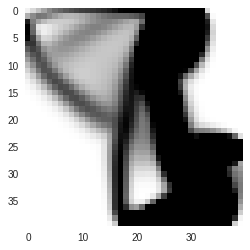

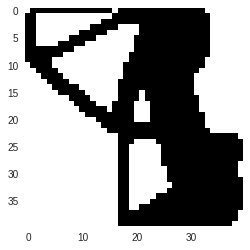

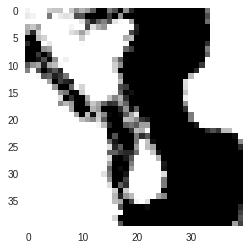

TRAIN COST @ EPOCH 0: 0.261161
TRAIN IOU  @ EPOCH 0: 0.689121
TEST  COST @ EPOCH 0: 0.163183
TEST  IOU  @ EPOCH 0: 0.792055
1
2
3
4
5


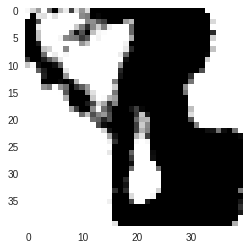

TRAIN COST @ EPOCH 5: 0.121447
TRAIN IOU  @ EPOCH 5: 0.874851
TEST  COST @ EPOCH 5: 0.128832
TEST  IOU  @ EPOCH 5: 0.877112
6
7
8
9
10


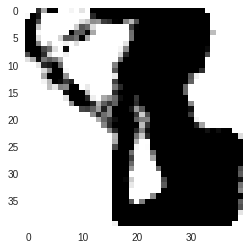

TRAIN COST @ EPOCH 10: 0.108628
TRAIN IOU  @ EPOCH 10: 0.890681
TEST  COST @ EPOCH 10: 0.122234
TEST  IOU  @ EPOCH 10: 0.891638
11
12
13
14
15


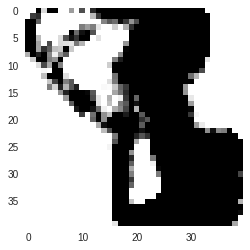

TRAIN COST @ EPOCH 15: 0.098669
TRAIN IOU  @ EPOCH 15: 0.899076
TEST  COST @ EPOCH 15: 0.122859
TEST  IOU  @ EPOCH 15: 0.899724
16
17
18
19
20


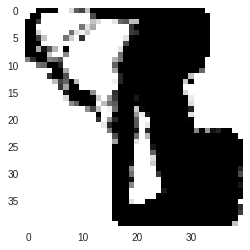

TRAIN COST @ EPOCH 20: 0.087386
TRAIN IOU  @ EPOCH 20: 0.905366
TEST  COST @ EPOCH 20: 0.130957
TEST  IOU  @ EPOCH 20: 0.905909
21
22
23
24
25


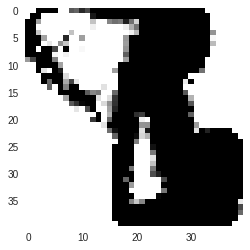

TRAIN COST @ EPOCH 25: 0.075060
TRAIN IOU  @ EPOCH 25: 0.910968
TEST  COST @ EPOCH 25: 0.141545
TEST  IOU  @ EPOCH 25: 0.911493
26
27
28
29
30


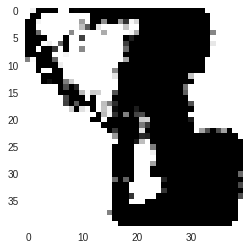

TRAIN COST @ EPOCH 30: 0.063881
TRAIN IOU  @ EPOCH 30: 0.916212
TEST  COST @ EPOCH 30: 0.163152
TEST  IOU  @ EPOCH 30: 0.916708
31
32
33
34
35


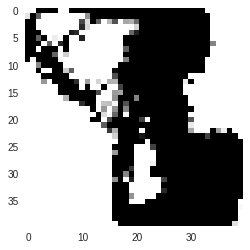

TRAIN COST @ EPOCH 35: 0.054885
TRAIN IOU  @ EPOCH 35: 0.921048
TEST  COST @ EPOCH 35: 0.185940
TEST  IOU  @ EPOCH 35: 0.921503
36
37
38
39
40


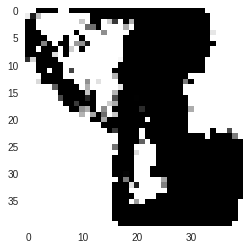

TRAIN COST @ EPOCH 40: 0.048998
TRAIN IOU  @ EPOCH 40: 0.925341
TEST  COST @ EPOCH 40: 0.212230
TEST  IOU  @ EPOCH 40: 0.925744
41
42
43
44
45


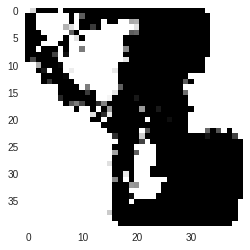

TRAIN COST @ EPOCH 45: 0.044349
TRAIN IOU  @ EPOCH 45: 0.929097
TEST  COST @ EPOCH 45: 0.231558
TEST  IOU  @ EPOCH 45: 0.929456
46
47
48
49
50


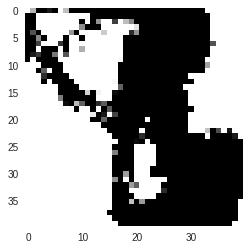

TRAIN COST @ EPOCH 50: 0.040938
TRAIN IOU  @ EPOCH 50: 0.932383
TEST  COST @ EPOCH 50: 0.253540
TEST  IOU  @ EPOCH 50: 0.932702
51
52
53
54
55


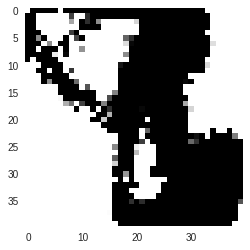

TRAIN COST @ EPOCH 55: 0.037996
TRAIN IOU  @ EPOCH 55: 0.935272
TEST  COST @ EPOCH 55: 0.270918
TEST  IOU  @ EPOCH 55: 0.935555
56
57
58
59
60


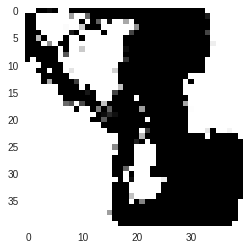

TRAIN COST @ EPOCH 60: 0.035680
TRAIN IOU  @ EPOCH 60: 0.937819
TEST  COST @ EPOCH 60: 0.286685
TEST  IOU  @ EPOCH 60: 0.938076
61
62
63
64
65


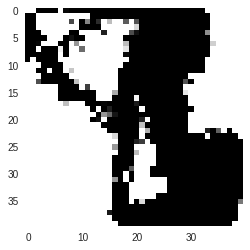

TRAIN COST @ EPOCH 65: 0.034092
TRAIN IOU  @ EPOCH 65: 0.940092
TEST  COST @ EPOCH 65: 0.302968
TEST  IOU  @ EPOCH 65: 0.940321
66
67
68
69
70


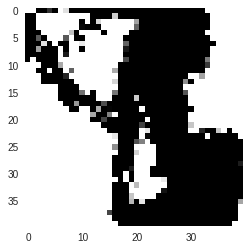

TRAIN COST @ EPOCH 70: 0.032564
TRAIN IOU  @ EPOCH 70: 0.942125
TEST  COST @ EPOCH 70: 0.314116
TEST  IOU  @ EPOCH 70: 0.942331
71
72
73
74
75


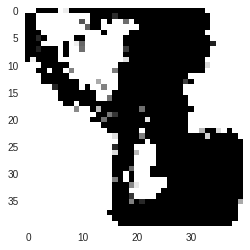

TRAIN COST @ EPOCH 75: 0.031032
TRAIN IOU  @ EPOCH 75: 0.943960
TEST  COST @ EPOCH 75: 0.330077
TEST  IOU  @ EPOCH 75: 0.944151
76
77
78
79
80


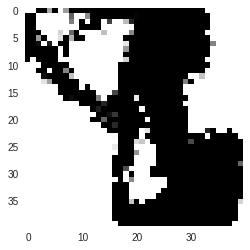

TRAIN COST @ EPOCH 80: 0.029637
TRAIN IOU  @ EPOCH 80: 0.945620
TEST  COST @ EPOCH 80: 0.343292
TEST  IOU  @ EPOCH 80: 0.945795
81
82
83
84
85


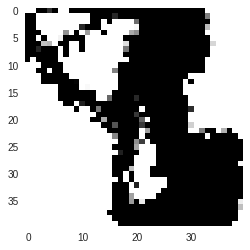

TRAIN COST @ EPOCH 85: 0.028475
TRAIN IOU  @ EPOCH 85: 0.947137
TEST  COST @ EPOCH 85: 0.354420
TEST  IOU  @ EPOCH 85: 0.947298
86
87
88
89
90


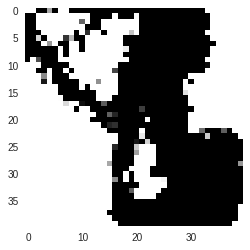

TRAIN COST @ EPOCH 90: 0.027903
TRAIN IOU  @ EPOCH 90: 0.948524
TEST  COST @ EPOCH 90: 0.366810
TEST  IOU  @ EPOCH 90: 0.948673
91
92
93
94
95


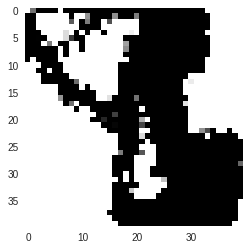

TRAIN COST @ EPOCH 95: 0.026815
TRAIN IOU  @ EPOCH 95: 0.949806
TEST  COST @ EPOCH 95: 0.378155
TEST  IOU  @ EPOCH 95: 0.949943
96
97
98
99


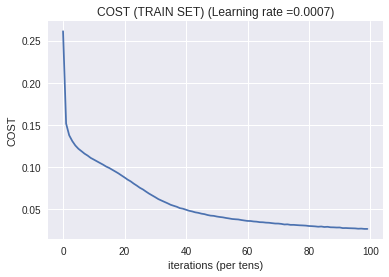

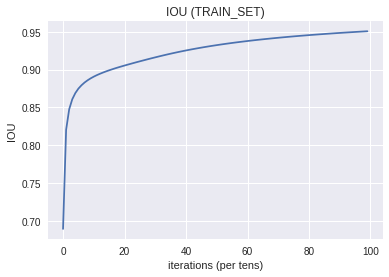

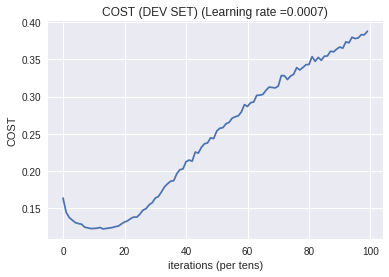

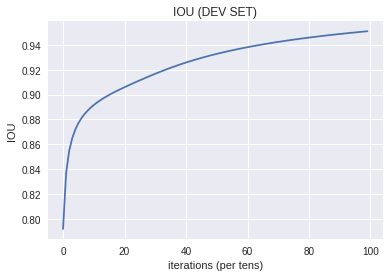

{'W1': <tf.Variable 'W1:0' shape=(3, 3, 1, 16) dtype=float32_ref>,
 'W10': <tf.Variable 'W10:0' shape=(3, 3, 32, 32) dtype=float32_ref>,
 'W11': <tf.Variable 'W11:0' shape=(3, 3, 48, 16) dtype=float32_ref>,
 'W12': <tf.Variable 'W12:0' shape=(3, 3, 16, 16) dtype=float32_ref>,
 'W13': <tf.Variable 'W13:0' shape=(1, 1, 16, 1) dtype=float32_ref>,
 'W2': <tf.Variable 'W2:0' shape=(3, 3, 16, 16) dtype=float32_ref>,
 'W3': <tf.Variable 'W3:0' shape=(3, 3, 16, 32) dtype=float32_ref>,
 'W4': <tf.Variable 'W4:0' shape=(3, 3, 32, 32) dtype=float32_ref>,
 'W5': <tf.Variable 'W5:0' shape=(3, 3, 32, 64) dtype=float32_ref>,
 'W6': <tf.Variable 'W6:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 'W7': <tf.Variable 'W7:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 'W8': <tf.Variable 'W8:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 'W9': <tf.Variable 'W9:0' shape=(3, 3, 96, 32) dtype=float32_ref>}

In [67]:
model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0007, num_epochs = 100, minibatch_size = 64, print_cost = True)